In [1]:
import os
import sys
import time

import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

import scipy.io.wavfile as wav

import importlib
import librosa
import soundfile as sf

import torchnet.meter as tnt
from collections import OrderedDict

from IPython.display import clear_output
from scipy.io.wavfile import write
import IPython

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))
sys.path.append(os.path.join(os.getcwd(), '../datasets/'))

import ai8x

from types import SimpleNamespace
from msnoise import MSnoise
import msnoise

from mixedkws import MixedKWS
import mixedkws


from torchvision import transforms

In [2]:
'''
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v2_0911Speed_DynAug","qat_best.pth.tar")             
mod = importlib.import_module("ai85net-kws20-v2")
model_file = "ai85net-kws20-v2"
'''

trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v3_0911Speed_DynAug","qat_best.pth.tar")              
mod = importlib.import_module("ai85net-kws20-v3")
model_file = "ai85net-kws20-v3"

'''
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_NAS_0911Speed_DynAug/","qat_best.pth.tar")
mod = importlib.import_module("ai85nasnet_kws20_res_1")
model_file = "ai85nasnet_kws20_res_1"
'''
dataset = importlib.import_module("kws20")

In [3]:
classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
           'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'unknown']

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=False, round_avg=False)
qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [5]:
'''
model = mod.AI85KWS20Netv2(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)
'''

model = mod.AI85KWS20Netv3(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

'''
model = mod.AI85NASNET_KWS20_RES_1(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=True, 
                           quantize_activation=False)

'''

checkpoint = torch.load(trained_checkpoint_path)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)


ai8x.update_model(model)

In [6]:
sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

# args = ('/data_ssd', Namespace(act_mode_8bit=False, activation_stats=[], avg_pool_rounding=False, batch_size=256, cnn='ai85kws20netv3', collate_fn=None, compress='policies/schedule_kws20.yaml', cpu=False, csv_prefix=None, data='/data_ssd', dataset='KWS_20', datasets_fn=<function KWS_20_get_datasets at 0x7f917f0f2040>, deterministic=True, device='cuda', dimensions=(128, 128, 1), display_confusion=True, display_embedding=False, display_prcurves=False, earlyexit_lossweights=None, earlyexit_thresholds=None, effective_test_size=1.0, effective_train_size=1.0, effective_valid_size=1.0, epochs=200, evaluate=False, extras=None, generate_sample=None, gpus=None, kd_distill_wt=0.5, kd_pretrained=False, kd_resume='', kd_start_epoch=0, kd_student_wt=0.5, kd_teacher=None, kd_teacher_wt=0.0, kd_temp=1.0, kernel_stats=False, labels=('up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'UNKNOWN'), load_model_path='', load_serialized=False, log_params_histograms=False, lr=0.001, masks_sparsity=False, momentum=0.9, name=None, nas=False, nas_kd_resume_from='', nas_policy='', nas_stage_transition_list=None, no_tensorboard=True, num_best_scores=1, num_classes=21, obj_detection=False, obj_detection_params=None, optimizer='Adam', out_fold_ratio=1, output_dir='logs', pretrained=False, print_freq=10, qat_policy='policies/qat_policy.yaml', qe_bits_accum=32, qe_bits_acts=8, qe_bits_wts=8, qe_calibration=None, qe_clip_acts=<ClipMode.NONE: 0>, qe_clip_n_stds=None, qe_config_file=None, qe_convert_pytorch=False, qe_dynamic=False, qe_mode=<LinearQuantMode.SYMMETRIC: 1>, qe_mode_acts=None, qe_mode_wts=None, qe_no_clip_layers=[], qe_no_quant_layers=[], qe_per_channel=False, qe_pytorch_backend='fbgemm', qe_save_fp_weights=False, qe_scale_approx_bits=None, qe_stats_file=None, quantize_eval=False, regression=False, reset_optimizer=False, resumed_checkpoint_path='', seed=None, sensitivity=None, sensitivity_range=[0.0, 0.95, 0.05], shap=0, show_train_accuracy='last_batch', sparsity_perf=False, summary=None, summary_filename='model', tblog=False, thinnify=False, truncate_testset=False, use_bias=False, validation_split=0.1, visualize_fn=<function visualize_data at 0x7f8fface3790>, weight_decay=0.0, workers=4))
_, test_dataset = dataset.KWS_20_get_datasets( ('/data_ssd/', sn), load_train=False, load_test=True)
_, test_noise = msnoise.MSnoise_get_datasets(('/data_ssd/', sn), load_train=False, load_test=True)

No key `stretch` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]

Processing test...
test set: 33015 elements
Class up (# 31): 1275 elements
Class down (# 5): 1218 elements
Class left (# 15): 1236 elements
Class right (# 23): 1188 elements
Class stop (# 27): 1233 elements
Class go (# 11): 1206 elements
Class yes (# 34): 1257 elements
Class no (# 19): 1215 elements
Class on (# 21): 1188 elements
Class off (# 20): 1206 elements
Class one (# 22): 1197 elements
Class two (# 30): 1272 elements
Class three (# 28): 1215 elements
Class four (# 10): 1200 elements
Class five (# 7): 1335 elements
Class six (# 26): 1182 elements
Class seven (# 24): 1218 elements
Class eight (# 6): 1224 elements
Class nine (# 18): 1224 elements
Class zero (# 35): 1254 elements
Class UNKNOWN: 8472 elements
torch.Size([56372, 128, 128])


Class AirConditioner, 0
Number of elements in class AirConditioner: 1224
AirConditioner: 0
Class AirportAnnouncements, 1
Number of elements in class AirportAn

In [7]:
originals = list(range(0, len(test_dataset), 3))
original_testdataset  = torch.utils.data.Subset(test_dataset, originals)
test_loader = torch.utils.data.DataLoader(original_testdataset, batch_size=256)

In [8]:
noise_dict = {}

for idx, i in enumerate(test_noise.classes):

    if list(test_noise.targets).count(idx) == 0:
        continue

    else:
        noise_dict[i] = idx

In [9]:
noise_list = noise_dict.keys()
noise_list = list(noise_list)
noise_list.append('WhiteNoise')

In [10]:
noise_dict

{'AirConditioner': 0,
 'AirportAnnouncements': 1,
 'Babble': 2,
 'CopyMachine': 6,
 'Munching': 12,
 'NeighborSpeaking': 13,
 'ShuttingDoor': 17,
 'Typing': 22,
 'VacuumCleaner': 23,
 'TradeShow': 26}

In [11]:
def evaluate(db, noise, noise_kind):

    if (noise == True) and (noise_kind == None):
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False

    model.eval()
    model.to(device)
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
    outputs_all = np.zeros((len(test_dataset), 21))
    targets_all = np.zeros((len(test_dataset)))

    transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
    if (noise == True) and (noise_kind != 'WhiteNoise'):
        test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                 transform=transform, quantize=True, download=False)
        
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):

            if noise == True:
                if noise_kind == 'WhiteNoise':
                    mean = 0
                    std = 1
                    random_noise = np.random.normal(mean, std, inputs.shape)
                    random_noise = torch.tensor(random_noise, dtype = torch.float32)
                    random_noise = np.clip(random_noise, -1, 1)
                else:
                    if (test_noise_dataset.data.shape[0] >= inputs.shape[0]):
                        random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                    else:
                        small_indx = np.random.randint(0, test_noise_dataset.data.shape[0], (inputs.shape[0] - test_noise_dataset.data.shape[0]))
                        random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                        random_noise = torch.cat([random_noise, random_noise[small_indx]], dim=0)
                inputs = MixedKWS.snr_mixer(inputs, random_noise, db)

            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            classerr.add(outputs, targets)

            print("Batch: [",batch_idx*256 ,"/", len(original_testdataset),"]")
            acc = classerr.value()[0]
            print("Accuracy: ", acc)
            outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
            targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
            
    print("Total Accuracy: ", acc)
    return acc

In [12]:
def snr_testing(noise = False, noise_kind = None):

    if noise == False:
        db = None

    time_s = time.time()
    print("Started evaluating :", trained_checkpoint_path)

    if noise == False:
        accuracies = np.zeros(1)
        snr = np.zeros(1)

        accuracies[0] = evaluate(db, noise, noise_kind)
        snr[0] = None
        
        dur = time.time() - time_s
        print(f'Finished in {dur:.3f} seconds.')
        return accuracies, snr
    
    accuracies = np.zeros(4)
    snr = np.zeros(4)

    for idx, db in enumerate([-5, 0, 10, 20]):
        print("Evaluating SNR levels of", db)
        accuracies[idx] = evaluate(db, noise, noise_kind)
        snr[idx] = db
    
    dur = time.time() - time_s
    print(f'Finished in {dur:.3f} seconds.')
    return accuracies, snr

In [13]:
def benchmark(noise_kinds):

    num = len(noise_kinds) + 1

    snr = np.zeros((num, 4))
    accuracies = np.zeros((num, 4))

    for idx, n in enumerate(noise_kinds):

        print(f'{n} Noise Evaluation')

        accuracies[idx], snr[idx] = snr_testing(noise = True, noise_kind = n)


    accuracies[-1], snr[-1] = snr_testing(noise= False)


    return accuracies, snr

In [14]:
accuracies_w, snr_w = benchmark(noise_list)

AirConditioner Noise Evaluation
Started evaluating : /home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v3_0911Speed_DynAug/qat_best.pth.tar
Evaluating SNR levels of -5


torch.Size([56372, 128, 128])


Class AirConditioner, 0
Number of elements in class AirConditioner: 1224
AirConditioner: 0
Number of elements in class unknown: 8206
[0]


Batch: [ 0 / 11005 ]
Accuracy:  48.046875
Batch: [ 256 / 11005 ]
Accuracy:  40.0390625
Batch: [ 512 / 11005 ]
Accuracy:  35.416666666666664
Batch: [ 768 / 11005 ]
Accuracy:  38.76953125
Batch: [ 1024 / 11005 ]
Accuracy:  48.51562499999999
Batch: [ 1280 / 11005 ]
Accuracy:  54.75260416666667
Batch: [ 1536 / 11005 ]
Accuracy:  58.70535714285714
Batch: [ 1792 / 11005 ]
Accuracy:  60.888671875
Batch: [ 2048 / 11005 ]
Accuracy:  61.71875
Batch: [ 2304 / 11005 ]
Accuracy:  58.67187499999999
Batch: [ 2560 / 11005 ]
Accuracy:  60.33380681818181
Batch: [ 2816 / 11005 ]
Accuracy:  61.9140625
Batch: [ 3072 / 11005 ]
Accuracy:  63.46153846153846
Batch: [ 3328 / 11005 ]
Accuracy:  63.03013392857143
Batch: [ 3584 / 11005 ]
Accuracy:  60.963541666666664
Batch: [ 3840 / 11005 ]
Accuracy:  60.83984375
Batch: [ 4096 / 11005 ]
Accuracy:

## Examples

In [74]:
def snr_mixer_manuel(clean, noise, snr):
    # Set the input clean range [-1,1]
    max_clean = torch.max(abs(clean.reshape(clean.shape[0], 16384)), 1, keepdims = True).values
    clean = clean * (torch.where(max_clean != 0, 1.0 / max_clean, max_clean)).unsqueeze(1)
    clean_ranged = clean
    
    # Set the noise range [-1,1]
    max_noise = torch.max(abs(noise.reshape(noise.shape[0], 16384)), 1, keepdims = True).values
    noise = noise * (torch.where(max_noise != 0, 1.0 / max_noise, max_noise)).unsqueeze(1)
    noise_ranged = noise

    # Normalizing to rms equal to 1
    rmsclean = torch.mean(clean[:, :125]**2)**0.5
    scalarclean = 1 / rmsclean
    clean = clean * scalarclean

    rmsnoise = torch.mean(noise[:, :125]**2)**0.5
    scalarnoise = 1 / rmsnoise

    # Set the noise level for a given SNR
    cleanfactor = 10**(snr/20)
    noisyspeech = cleanfactor*clean + noise
    noisyspeech = noisyspeech / (scalarnoise + cleanfactor * scalarclean)

    # Set the output range [-1,1]
    max_mixed = torch.max(abs(noisyspeech.reshape(noisyspeech.shape[0], 16384)), 1, keepdims = True).values
    noisyspeech = noisyspeech * (torch.where(max_mixed != 0, 1.0 / max_mixed, max_mixed)).unsqueeze(1)

    plots = (clean_ranged , noise_ranged, cleanfactor*clean)
    return noisyspeech, plots

### Babble Example

#### Codes

In [13]:
noise = True
noise_kind = 'Babble'
idx = 0

transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
if (noise == True) and (noise_kind != 'WhiteNoise'):
    test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                transform=transform, quantize=True, download=False)
    
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if noise == True:
            if noise_kind == 'WhiteNoise':
                mean = 0
                std = 1
                random_noise = np.random.normal(mean, std, inputs.shape)
                random_noise = torch.tensor(random_noise, dtype = torch.float32)
                random_noise = np.clip(random_noise, -1, 1)
            else:
                if (test_noise_dataset.data.shape[0] >= inputs.shape[0]):
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                else:
                    small_indx = np.random.randint(0, test_noise_dataset.data.shape[0], (inputs.shape[0] - test_noise_dataset.data.shape[0]))
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                    random_noise = torch.cat([random_noise, random_noise[small_indx]], dim=0)
                    
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/noise.wav', 16384, np.array(random_noise[idx]).flatten('F'))

            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/input.wav', 16384, np.array(inputs[idx]).flatten('F'))

            mixed_5,plot_5 = snr_mixer_manuel(inputs, random_noise, -5)
            


            print('SNR Mixer -5db')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/mixed-5.wav', 16384, np.array(mixed_5[idx]).flatten('F'))
            break

torch.Size([56372, 128, 128])


Class Babble, 2
Number of elements in class Babble: 1436
Babble: 0
Number of elements in class unknown: 7994
[0]




ValueError: too many values to unpack (expected 2)

#### Audios

input audio

In [72]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/input.wav', rate = 16384)

noise audio

In [71]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/noise.wav', rate = 16384)

snr mixed -5db

In [73]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/mixed-5.wav', rate = 16384)

snr mixed 0db

In [74]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/mixed0.wav', rate = 16384)

snr mixed 20db

In [75]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/mixed20.wav', rate = 16384)

#### Plots

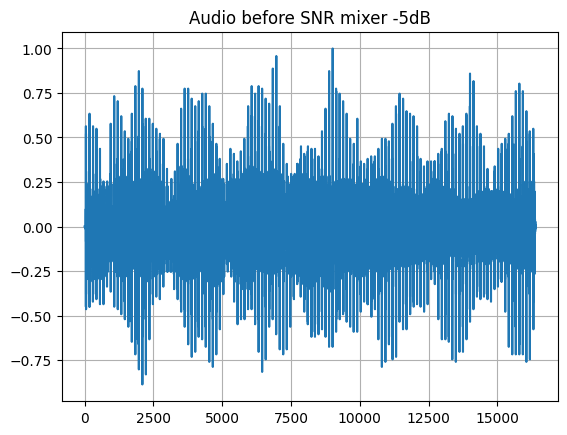

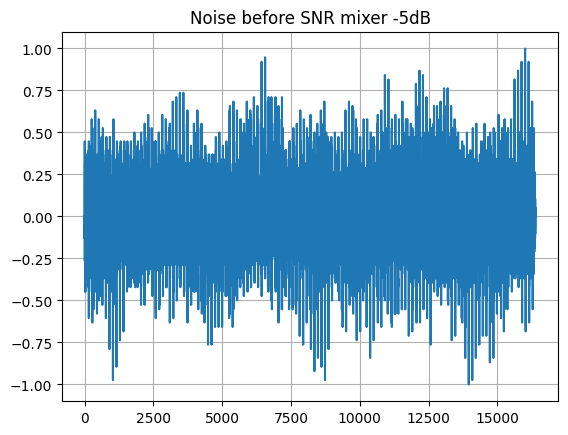

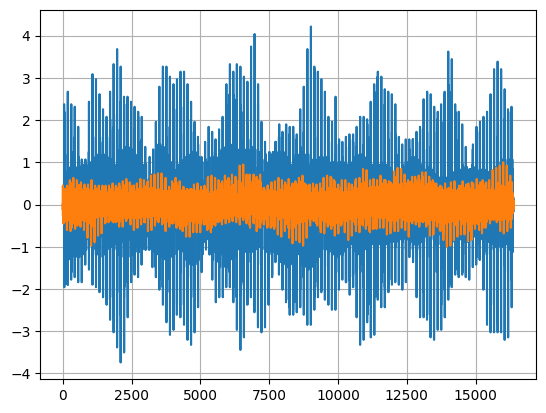

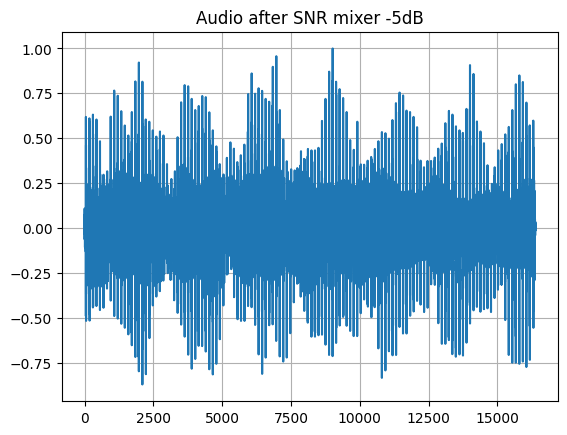

In [69]:
clean_5, noise_5, clean_after = plot_5
plt.figure()
plt.grid()
plt.title('Audio before SNR mixer -5dB')
plt.plot(clean_5[50].flatten())
plt.figure()
plt.title('Noise before SNR mixer -5dB')
plt.grid()
plt.plot(noise_5[50].flatten())

plt.figure()
plt.grid()
plt.plot(clean_after[50].flatten())
plt.plot(noise_5[50].flatten())

plt.figure()
plt.title('Audio after SNR mixer -5dB')
plt.grid()
plt.plot(mixed_5[50].flatten())

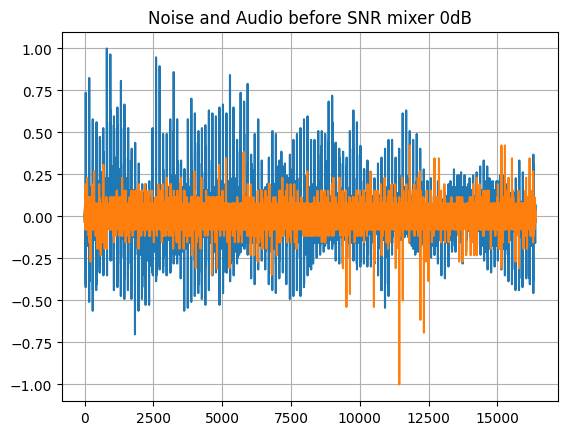

In [46]:
clean0, noise0 = plot_0
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 0dB')
plt.plot(clean0[idx].flatten())
plt.plot(noise0[idx].flatten())

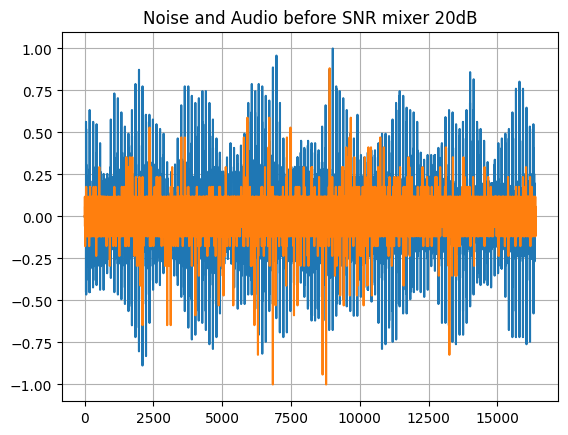

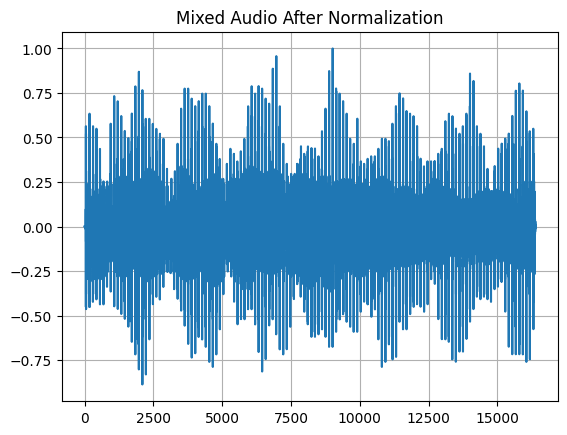

In [48]:
clean20, noise20 = plot_20
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 20dB')
plt.plot(clean20[50].flatten())
plt.plot(noise20[50].flatten())

plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_20[50].flatten())

### Vacuum Cleaner Example

#### Codes

In [75]:
noise = True
noise_kind = 'VacuumCleaner'
idx = 0

transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
if (noise == True) and (noise_kind != 'WhiteNoise'):
    test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                transform=transform, quantize=True, download=False)
    
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if noise == True:
            if noise_kind == 'WhiteNoise':
                mean = 0
                std = 1
                random_noise = np.random.normal(mean, std, inputs.shape)
                random_noise = torch.tensor(random_noise, dtype = torch.float32)
                random_noise = np.clip(random_noise, -1, 1)
            else:
                if (test_noise_dataset.data.shape[0] >= inputs.shape[0]):
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                else:
                    small_indx = np.random.randint(0, test_noise_dataset.data.shape[0], (inputs.shape[0] - test_noise_dataset.data.shape[0]))
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                    random_noise = torch.cat([random_noise, random_noise[small_indx]], dim=0)
            print('Random Noise')
            print(f'Noise max: {random_noise[idx].max()}')
            print(f'Noise min: {random_noise[idx].min()}')
            print(f'Noise mean: {random_noise[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/noise.wav', 16384, np.array(random_noise[0]).flatten('F'))

            print('Inputs')
            print(f'Input max: {inputs[idx].max()}')
            print(f'Input min: {inputs[idx].min()}')
            print(f'Input mean: {inputs[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/input.wav', 16384, np.array(inputs[0]).flatten('F'))

            mixed_5,plot_5 = snr_mixer_manuel(inputs, random_noise, -5)

            print('SNR Mixer -5db')
            print(f'Input max: {mixed_5[idx].max()}')
            print(f'Input min: {mixed_5[idx].min()}')
            print(f'Input mean: {mixed_5[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed-5.wav', 16384, np.array(mixed_5[0]).flatten('F'))

            mixed_0,plot_0 = snr_mixer_manuel(inputs, random_noise, 0)

            print('SNR Mixer 0db')
            print(f'Input max: {mixed_0[idx].max()}')
            print(f'Input min: {mixed_0[idx].min()}')
            print(f'Input mean: {mixed_0[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed0.wav', 16384, np.array(mixed_0[0]).flatten('F'))

            mixed_20,plot_20 = snr_mixer_manuel(inputs, random_noise, 20)

            print('SNR Mixer 20db')
            print(f'Input max: {mixed_20[idx].max()}')
            print(f'Input min: {mixed_20[idx].min()}')
            print(f'Input mean: {mixed_20[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed20.wav', 16384, np.array(mixed_20[0]).flatten('F'))
        break

torch.Size([56372, 128, 128])


Class VacuumCleaner, 24
Number of elements in class VacuumCleaner: 135
VacuumCleaner: 0
Number of elements in class unknown: 9295
[0]


Random Noise
Noise max: 0.34375
Noise min: -0.3046875
Noise mean: -0.0003705024719238281

Inputs
Input max: 0.4453125
Input min: -0.3125
Input mean: 0.00022268295288085938

SNR Mixer -5db
Input max: 1.0
Input min: -0.7343452572822571
Input mean: 0.0002518274704925716

SNR Mixer 0db
Input max: 1.0
Input min: -0.7209343910217285
Input mean: 0.0003628648119047284

SNR Mixer 20db
Input max: 0.9999999403953552
Input min: -0.703640878200531
Input mean: 0.00048656557919457555



#### Audios

input audio

In [76]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/input.wav', rate = 16384)

noise audio

In [77]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/noise.wav', rate = 16384)

snr mixed -5db

In [78]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed-5.wav', rate = 16384)

snr mixed 0db

In [79]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed0.wav', rate = 16384)

snr mixed 20db

In [80]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed20.wav', rate = 16384)

#### Plots

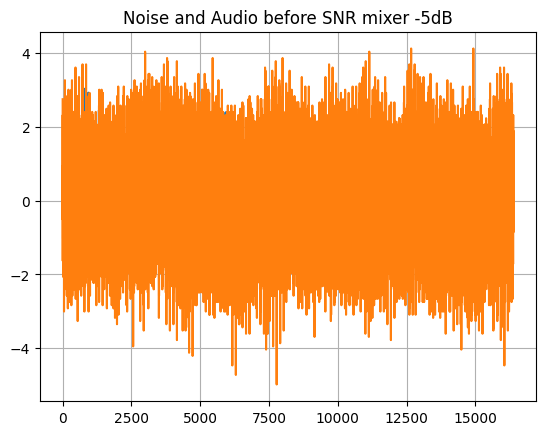

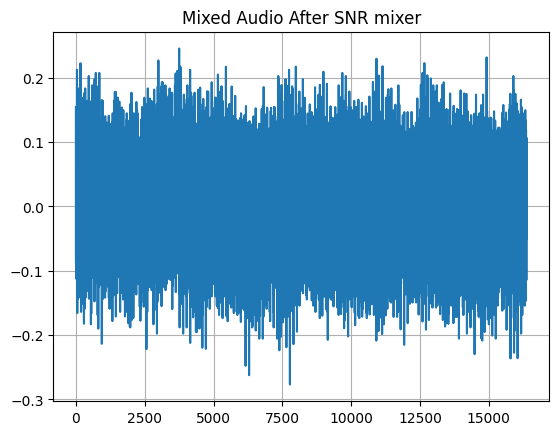

In [36]:
clean_5, noise_5, noisyspeech_5 = plot_5
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer -5dB')
plt.plot(clean_5[idx].flatten())
plt.plot(noise_5[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After SNR mixer')
plt.plot(mixed_5[idx].flatten())

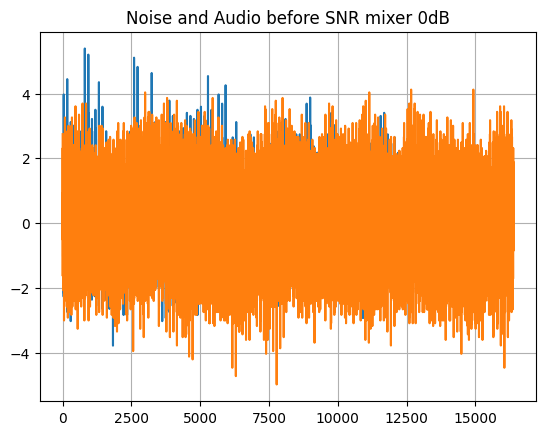

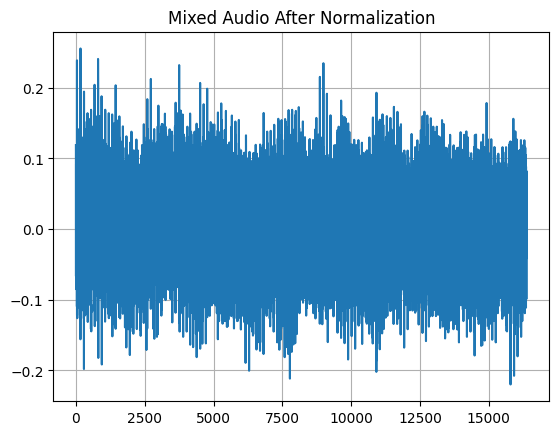

In [37]:
clean0, noise0, noisyspeech0 = plot_0
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 0dB')
plt.plot(clean0[idx].flatten())
plt.plot(noise0[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_0[idx].flatten())

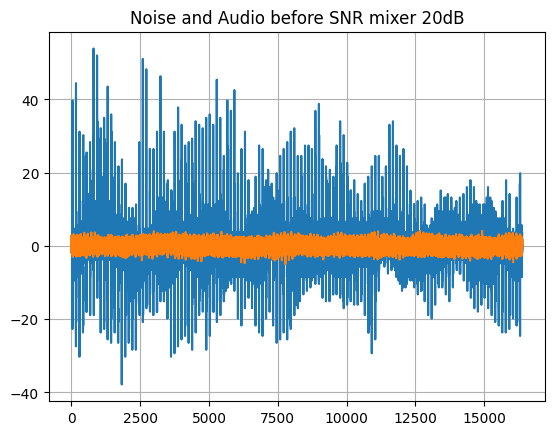

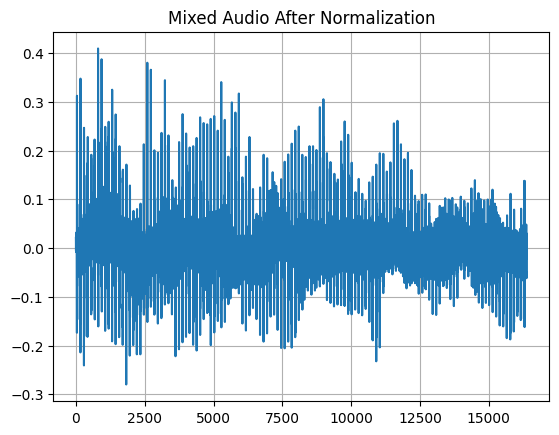

In [38]:
clean20, noise20, noisyspeech20 = plot_20
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 20dB')
plt.plot(clean20[idx].flatten())
plt.plot(noise20[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_20[idx].flatten())

### Typing Example

#### Codes

torch.Size([56372, 128, 128])


Class Typing, 23
Number of elements in class Typing: 1683
Typing: 0
Number of elements in class unknown: 7747
[0]


Random Noise
Noise max: 0.0078125
Noise min: -0.0078125
Noise mean: 2.86102294921875e-06

Inputs
Input max: 0.4453125
Input min: -0.3125
Input mean: 0.00022268295288085938

SNR Mixer -5db
Input max: 1.0
Input min: -0.7017543911933899
Input mean: 0.0005869426531717181

SNR Mixer 0db
Input max: 1.0
Input min: -0.7017544507980347
Input mean: 0.0005489173927344382

SNR Mixer 20db
Input max: 1.0
Input min: -0.7017543911933899
Input mean: 0.0005049458704888821



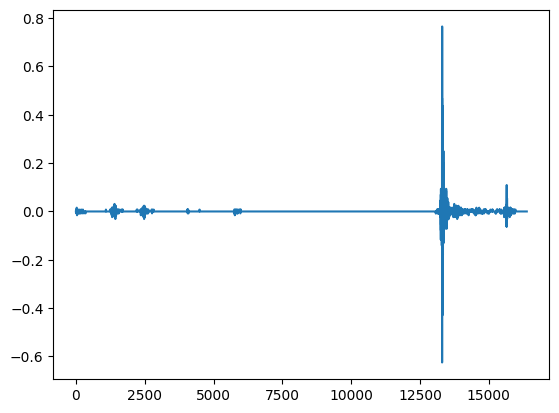

In [123]:
noise = True
noise_kind = 'Typing'
idx = 0

transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
if (noise == True) and (noise_kind != 'WhiteNoise'):
    test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                transform=transform, quantize=True, download=False)
    
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if noise == True:
            if noise_kind == 'WhiteNoise':
                mean = 0
                std = 1
                random_noise = np.random.normal(mean, std, inputs.shape)
                random_noise = torch.tensor(random_noise, dtype = torch.float32)
                random_noise = np.clip(random_noise, -1, 1)
            else:
                if (test_noise_dataset.data.shape[0] >= inputs.shape[0]):
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = False)))[0]
                else:
                    small_indx = np.random.randint(0, test_noise_dataset.data.shape[0], (inputs.shape[0] - test_noise_dataset.data.shape[0]))
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                    random_noise = torch.cat([random_noise, random_noise[small_indx]], dim=0)

            print('Random Noise')
            print(f'Noise max: {random_noise[idx].max()}')
            print(f'Noise min: {random_noise[idx].min()}')
            print(f'Noise mean: {random_noise[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/noise.wav', 16384, np.array(random_noise[20]).flatten('F'))

            plt.plot(np.array(random_noise[20]).flatten('F'))

            print('Inputs')
            print(f'Input max: {inputs[idx].max()}')
            print(f'Input min: {inputs[idx].min()}')
            print(f'Input mean: {inputs[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/input.wav', 16384, np.array(inputs[0]).flatten('F'))

            mixed_5,plot_5 = snr_mixer_manuel(inputs, random_noise, -5)

            print('SNR Mixer -5db')
            print(f'Input max: {mixed_5[idx].max()}')
            print(f'Input min: {mixed_5[idx].min()}')
            print(f'Input mean: {mixed_5[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed-5.wav', 16384, np.array(mixed_5[0]).flatten('F'))

            mixed_0,plot_0 = snr_mixer_manuel(inputs, random_noise, 0)

            print('SNR Mixer 0db')
            print(f'Input max: {mixed_0[idx].max()}')
            print(f'Input min: {mixed_0[idx].min()}')
            print(f'Input mean: {mixed_0[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed0.wav', 16384, np.array(mixed_0[0]).flatten('F'))

            mixed_20,plot_20 = snr_mixer_manuel(inputs, random_noise, 20)

            print('SNR Mixer 20db')
            print(f'Input max: {mixed_20[idx].max()}')
            print(f'Input min: {mixed_20[idx].min()}')
            print(f'Input mean: {mixed_20[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed20.wav', 16384, np.array(mixed_20[0]).flatten('F'))
        break

In [124]:
write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/test.wav', 16384, np.array(test_noise_dataset[20][0]).flatten('F'))

In [125]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/test.wav', rate = 16384)

#### Audios

input audio

In [82]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/input.wav', rate = 16384)

noise audio

In [126]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/noise.wav', rate = 16384)

In [104]:
sample = librosa.load('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/noise.wav', 16384)

/tmp/ipykernel_199919/3785790159.py:1: FutureWarning: Pass sr=16384 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  sample = librosa.load('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/noise.wav', 16384)


In [105]:
sample[1]

16384

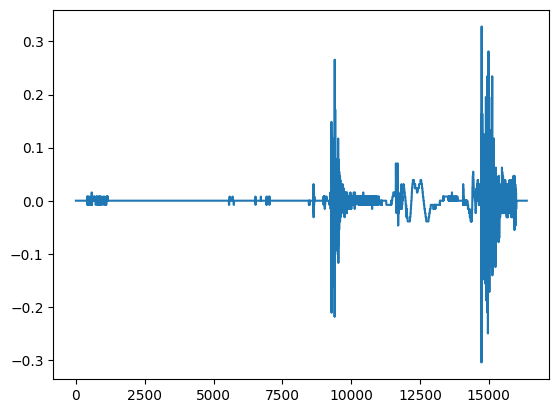

In [106]:
plt.plot(sample[0])

snr mixed -5db

In [127]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed-5.wav', rate = 16384)

snr mixed 0db

In [85]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed0.wav', rate = 16384)

snr mixed 20db

In [86]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed20.wav', rate = 16384)

#### Plots

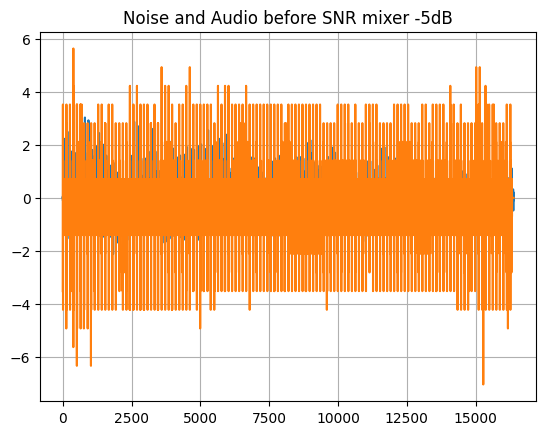

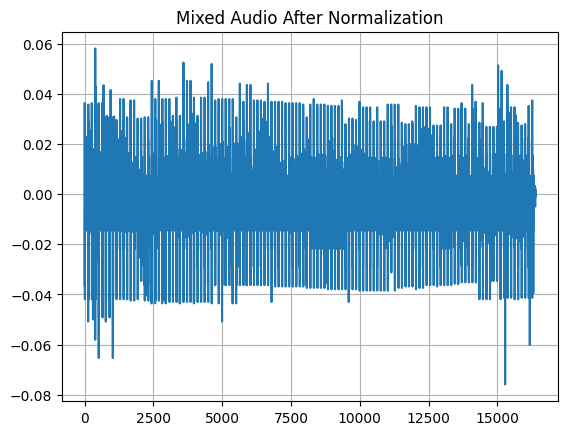

In [22]:
clean_5, noise_5, noisyspeech_5 = plot_5
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer -5dB')
plt.plot(clean_5[idx].flatten())
plt.plot(noise_5[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_5[idx].flatten())

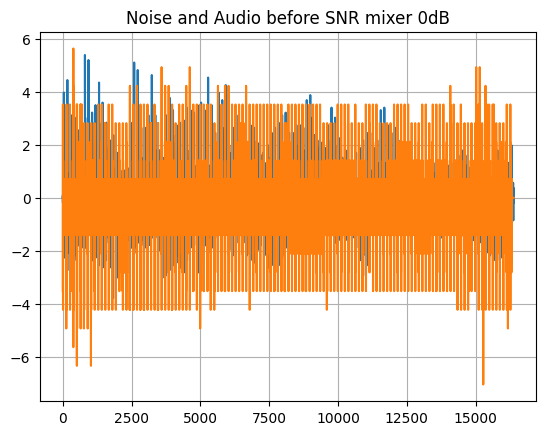

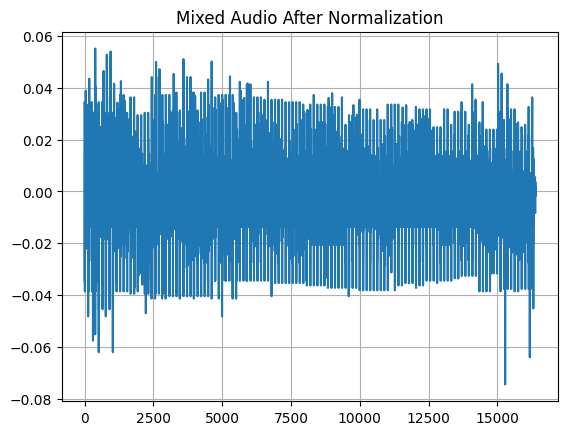

In [23]:
clean0, noise0, noisyspeech0 = plot_0
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 0dB')
plt.plot(clean0[idx].flatten())
plt.plot(noise0[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_0[idx].flatten())

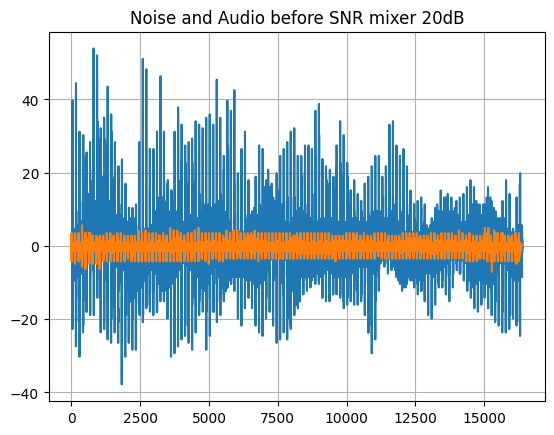

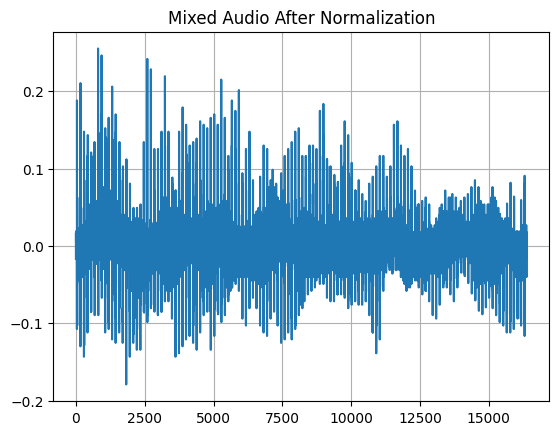

In [24]:
clean20, noise20, noisyspeech20 = plot_20
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 20dB')
plt.plot(clean20[idx].flatten())
plt.plot(noise20[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_20[idx].flatten())

### WhiteNoise Example

#### Codes

In [48]:
noise = True
noise_kind = 'WhiteNoise'
idx = 0

transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
if (noise == True) and (noise_kind != 'WhiteNoise'):
    test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                transform=transform, quantize=True, download=False)
    
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if noise == True:
            if noise_kind == 'WhiteNoise':
                mean = 0
                std = 1
                random_noise = np.random.normal(mean, std, inputs.shape)
                random_noise = torch.tensor(random_noise, dtype = torch.float32)
                random_noise = np.clip(random_noise, -1, 1)
            else:
                if (test_noise_dataset.data.shape[0] >= inputs.shape[0]):
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                else:
                    small_indx = np.random.randint(0, test_noise_dataset.data.shape[0], (inputs.shape[0] - test_noise_dataset.data.shape[0]))
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                    random_noise = torch.cat([random_noise, random_noise[small_indx]], dim=0)

            print('Random Noise')
            print(f'Noise max: {random_noise[idx].max()}')
            print(f'Noise min: {random_noise[idx].min()}')
            print(f'Noise mean: {random_noise[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/noise.wav', 16384, np.array(random_noise[0]).flatten('F'))

            print('Inputs')
            print(f'Input max: {inputs[idx].max()}')
            print(f'Input min: {inputs[idx].min()}')
            print(f'Input mean: {inputs[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/input.wav', 16384, np.array(inputs[0]).flatten('F'))

            mixed_5,plot_5 = snr_mixer_manuel(inputs, random_noise, -5)

            print('SNR Mixer -5db')
            print(f'Input max: {mixed_5[idx].max()}')
            print(f'Input min: {mixed_5[idx].min()}')
            print(f'Input mean: {mixed_5[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed-5.wav', 16384, np.array(mixed_5[0]).flatten('F'))

            mixed_0,plot_0 = snr_mixer_manuel(inputs, random_noise, 0)

            print('SNR Mixer 0db')
            print(f'Input max: {mixed_0[idx].max()}')
            print(f'Input min: {mixed_0[idx].min()}')
            print(f'Input mean: {mixed_0[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed0.wav', 16384, np.array(mixed_0[0]).flatten('F'))

            mixed_20,plot_20 = snr_mixer_manuel(inputs, random_noise, 20)

            print('SNR Mixer 20db')
            print(f'Input max: {mixed_20[idx].max()}')
            print(f'Input min: {mixed_20[idx].min()}')
            print(f'Input mean: {mixed_20[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed20.wav', 16384, np.array(mixed_20[0]).flatten('F'))
        break

Random Noise
Noise max: 1.0
Noise min: -1.0
Noise mean: 0.0037353672087192535

Inputs
Input max: 0.4453125
Input min: -0.3125
Input mean: 0.00022268295288085938

SNR Mixer -5db
Input max: 0.4745730459690094
Input min: -0.34483802318573
Input mean: 0.0008187702624127269

SNR Mixer 0db
Input max: 0.4324195384979248
Input min: -0.2922762334346771
Input mean: 0.0005847800057381392

SNR Mixer 20db
Input max: 0.4300653636455536
Input min: -0.29827237129211426
Input mean: 0.0002625955094117671



#### Audios

input audio

In [49]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/input.wav', rate = 16384)

noise audio

In [50]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/noise.wav', rate = 16384)

snr mixed -5db

In [51]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed-5.wav', rate = 16384)

snr mixed 0db

In [52]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed0.wav', rate = 16384)

snr mixed 20db

In [53]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed20.wav', rate = 16384)

#### Plots

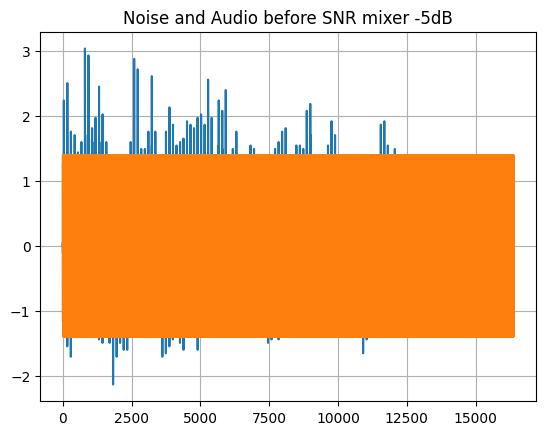

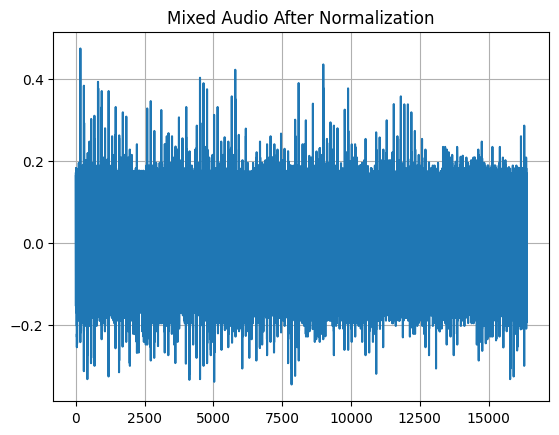

In [54]:
clean_5, noise_5, noisyspeech_5 = plot_5
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer -5dB')
plt.plot(clean_5[idx].flatten())
plt.plot(noise_5[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_5[idx].flatten())

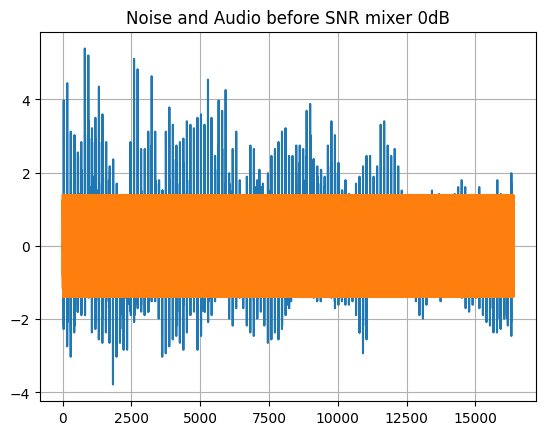

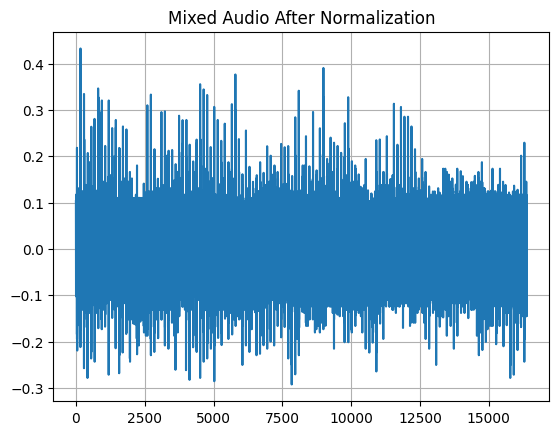

In [55]:
clean0, noise0, noisyspeech0 = plot_0
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 0dB')
plt.plot(clean0[idx].flatten())
plt.plot(noise0[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_0[idx].flatten())

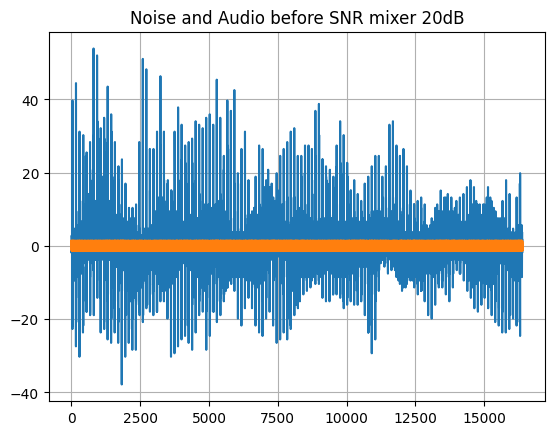

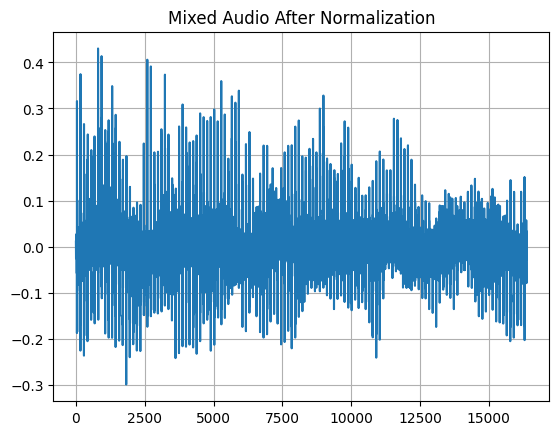

In [56]:
clean20, noise20, noisyspeech20 = plot_20
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 20dB')
plt.plot(clean20[idx].flatten())
plt.plot(noise20[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_20[idx].flatten())

## CSV Application

In [15]:
snr = [-5, 0, 10, 20]

In [16]:
csv ={}

for idx, i in enumerate(noise_list):
    csv[i] = accuracies_w[idx]
    
csv_list = []

csv_list.append(['raw', 'None', accuracies_w[-1][0]])
for i in csv.keys():
    for idx, j in enumerate(csv[i]):
        csv_list.append([i, snr[idx], j])

In [17]:
csv_list

[['raw', 'None', 90.80417991821899],
 ['AirConditioner', -5, 70.91322126306224],
 ['AirConditioner', 0, 81.96274420717855],
 ['AirConditioner', 10, 88.95956383462062],
 ['AirConditioner', 20, 90.09541117673785],
 ['AirportAnnouncements', -5, 68.69604725124942],
 ['AirportAnnouncements', 0, 80.3634711494775],
 ['AirportAnnouncements', 10, 88.38709677419355],
 ['AirportAnnouncements', 20, 89.92276238073603],
 ['Babble', -5, 63.98000908677874],
 ['Babble', 0, 78.23716492503408],
 ['Babble', 10, 88.40527033166742],
 ['Babble', 20, 89.88641526578827],
 ['CopyMachine', -5, 81.66288050885962],
 ['CopyMachine', 0, 86.61517492049069],
 ['CopyMachine', 10, 89.45024988641526],
 ['CopyMachine', 20, 90.24079963652885],
 ['Munching', -5, 86.97864606996819],
 ['Munching', 0, 88.44161744661517],
 ['Munching', 10, 89.69559291231258],
 ['Munching', 20, 90.14084507042254],
 ['NeighborSpeaking', -5, 57.492049068605176],
 ['NeighborSpeaking', 0, 72.34893230349842],
 ['NeighborSpeaking', 10, 87.523852794184

In [18]:
df = pd.DataFrame(csv_list, columns = ['Type', 'SNR (dB)', f'{model_file}'])

In [19]:
df

Type SNR (dB)  ai85net-kws20-v3
0                    raw     None         90.804180
1         AirConditioner       -5         70.913221
2         AirConditioner        0         81.962744
3         AirConditioner       10         88.959564
4         AirConditioner       20         90.095411
5   AirportAnnouncements       -5         68.696047
6   AirportAnnouncements        0         80.363471
7   AirportAnnouncements       10         88.387097
8   AirportAnnouncements       20         89.922762
9                 Babble       -5         63.980009
10                Babble        0         78.237165
11                Babble       10         88.405270
12                Babble       20         89.886415
13           CopyMachine       -5         81.662881
14           CopyMachine        0         86.615175
15           CopyMachine       10         89.450250
16           CopyMachine       20         90.240800
17              Munching       -5         86.978646
18              Munching        0         88.441617
19              Munching       10         89.695593
20              Munching       20         90.140845
21      NeighborSpeaking       -5         57.492049
22      NeighborSpeaking        0         72.348932
23      NeighborSpeaking       10         87.523853
24      NeighborSpeaking       20         89.840981
25          ShuttingDoor       -5         84.479782
26          ShuttingDoor        0         86.887778
27          ShuttingDoor       10         89.377556
28          ShuttingDoor       20         89.886415
29                Typing       -5         88.250795
30                Typing        0         89.141299
31                Typing       10         89.931849
32                Typing       20         90.204453
33         VacuumCleaner       -5         54.111767
34         VacuumCleaner        0         67.442072
35         VacuumCleaner       10         81.172194
36         VacuumCleaner       20         87.178555
37             TradeShow       -5         75.820082
38             TradeShow        0         82.626079
39             TradeShow       10         88.341663
40             TradeShow       20         89.868242
41            WhiteNoise       -5         61.044980
42            WhiteNoise        0         78.482508
43            WhiteNoise       10         88.477965
44            WhiteNoise       20         90.186279

In [20]:
if os.path.exists('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv'):
    current = pd.read_csv('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv', decimal=',', sep=';')
    if model_file in current.columns:
        print(f'This model file ({model_file}) already exists!')
    else:
        current[model_file] = list(df[model_file].values)
        current.to_csv('acc.csv', sep=';', decimal=',', index=False)

else:
    df.to_csv('acc.csv', sep=';', decimal=',', index=False)

In [21]:
pd.read_csv('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv', decimal=',', sep=';')

Type  SNR (dB)  ai85nasnet_kws20_res_1  ai85net-kws20-v2  \
0                    raw       NaN               93.766470         92.021808   
1         AirConditioner      -5.0               81.844616         78.673330   
2         AirConditioner       0.0               87.860064         86.524307   
3         AirConditioner      10.0               92.130850         90.404362   
4         AirConditioner      20.0               93.421172         91.049523   
5   AirportAnnouncements      -5.0               79.691050         74.802363   
6   AirportAnnouncements       0.0               87.005906         85.015902   
7   AirportAnnouncements      10.0               91.958201         90.186279   
8   AirportAnnouncements      20.0               93.212176         91.231259   
9                 Babble      -5.0               74.447978         70.013630   
10                Babble       0.0               85.851886         83.207633   
11                Babble      10.0               91.812812         90.031804   
12                Babble      20.0               93.248523         91.040436   
13           CopyMachine      -5.0               86.896865         84.388914   
14           CopyMachine       0.0               90.204453         88.359836   
15           CopyMachine      10.0               92.830532         90.713312   
16           CopyMachine      20.0               93.502953         91.176738   
17              Munching      -5.0               89.486597         87.432985   
18              Munching       0.0               91.476602         89.650159   
19              Munching      10.0               92.875965         91.122217   
20              Munching      20.0               93.439346         91.385734   
21      NeighborSpeaking      -5.0               62.244434         60.318037   
22      NeighborSpeaking       0.0               75.910950         75.174920   
23      NeighborSpeaking      10.0               90.895048         88.468878   
24      NeighborSpeaking      20.0               93.375738         90.976829   
25          ShuttingDoor      -5.0               87.523853         84.734212   
26          ShuttingDoor       0.0               89.877328         88.296229   
27          ShuttingDoor      10.0               92.530668         90.567924   
28          ShuttingDoor      20.0               93.248523         91.140391   
29                Typing      -5.0               91.040436         89.459337   
30                Typing       0.0               92.012721         90.413448   
31                Typing      10.0               93.103135         91.158564   
32                Typing      20.0               93.484780         91.158564   
33         VacuumCleaner      -5.0               71.340300         63.843707   
34         VacuumCleaner       0.0               81.099500         75.520218   
35         VacuumCleaner      10.0               90.195366         86.696956   
36         VacuumCleaner      20.0               93.094048         90.386188   
37             TradeShow      -5.0               84.352567         80.154475   
38             TradeShow       0.0               88.723308         86.715129   
39             TradeShow      10.0               91.967288         90.022717   
40             TradeShow      20.0               93.393912         91.067697   
41            WhiteNoise      -5.0               72.676056         71.594730   
42            WhiteNoise       0.0               85.252158         82.744207   
43            WhiteNoise      10.0               92.221717         89.931849   
44            WhiteNoise      20.0               93.393912         91.067697   

    ai85net-kws20-v3  
0          90.804180  
1          70.913221  
2          81.962744  
3          88.959564  
4          90.095411  
5          68.696047  
6          80.363471  
7          88.387097  
8          89.922762  
9          63.980009  
10         78.237165  
11         88.405270  
12         89.886415  
13         81.662

## CSV Plotting

In [22]:
data_files = pd.read_csv('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv', decimal=',', sep=';')

In [23]:
def plot(model_number):

    accuracies_values = {}

    for noise in noise_list:
        acc_list = []
        for idx, i in enumerate(data_files['Type'].values[1:]): 
            if i == noise:
                acc_list.append(data_files[model_number][1:][idx+1])
        accuracies_values[noise] = acc_list

    return accuracies_values

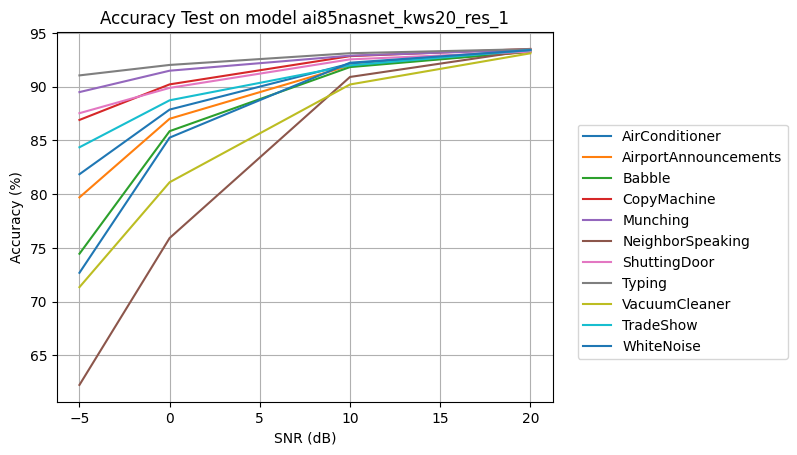

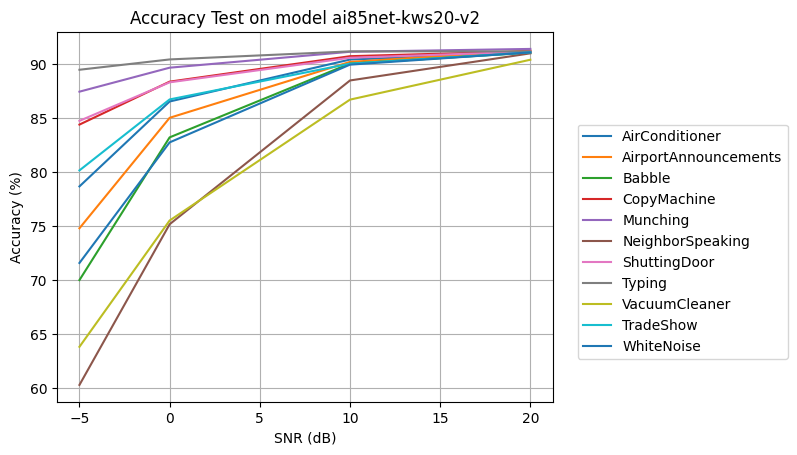

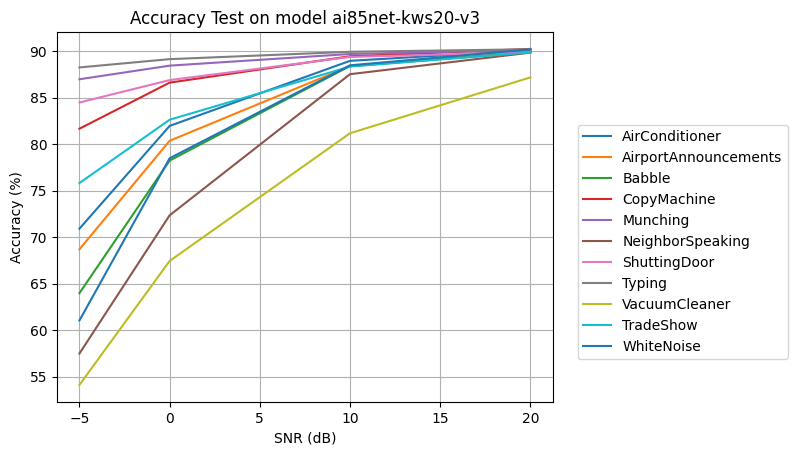

In [24]:
snr = [-5, 0, 10, 20]

for model_num in data_files.columns[2:]:
    accuracies_values = plot(model_num)
    plt.figure()
    plt.grid()
    for noise in noise_list:
        plt.title(f'Accuracy Test on model {model_num}') #duzelecek
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy (%)')
        plt.plot(snr, accuracies_values[noise])

    plt.legend(noise_list, bbox_to_anchor=(1.05, 0.75),
                         loc='upper left', borderaxespad=0.)

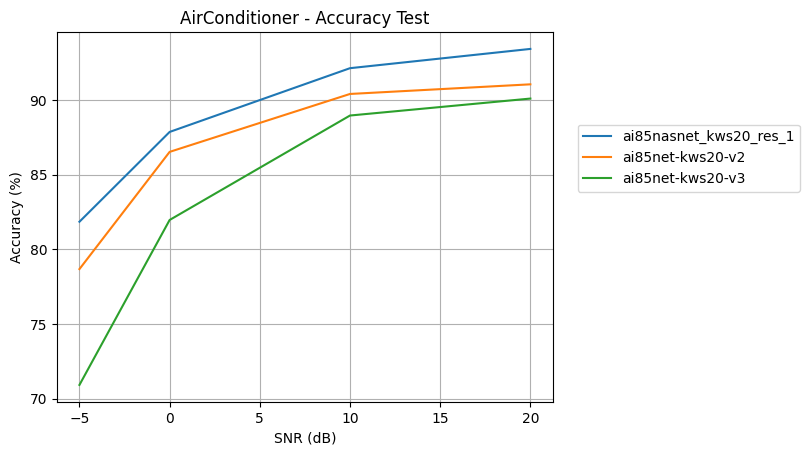

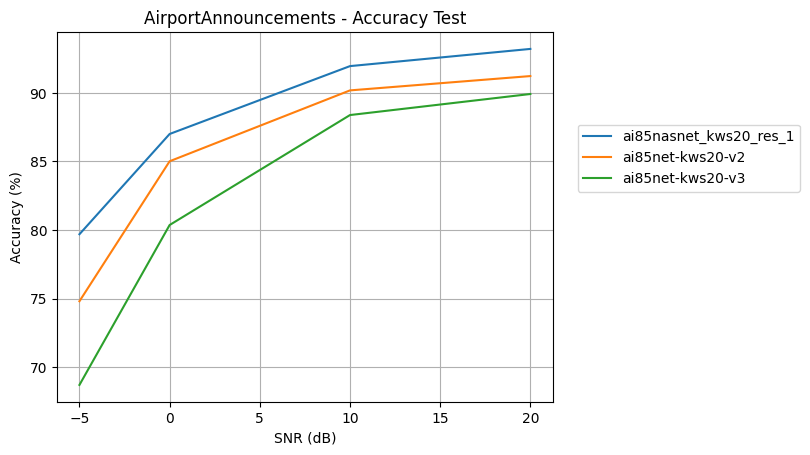

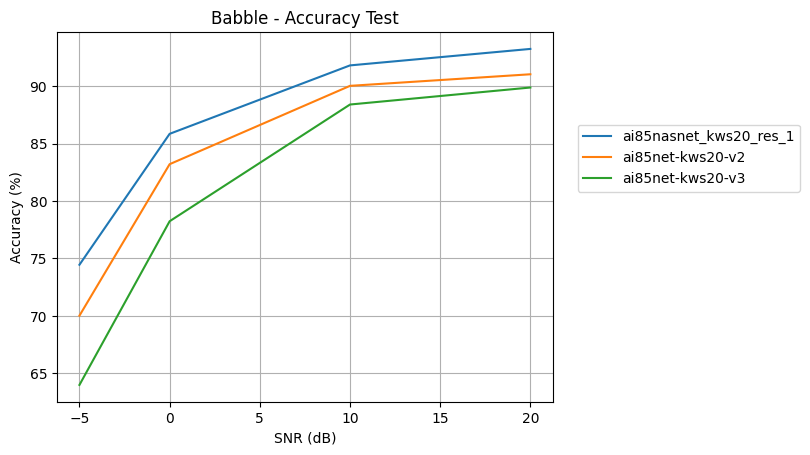

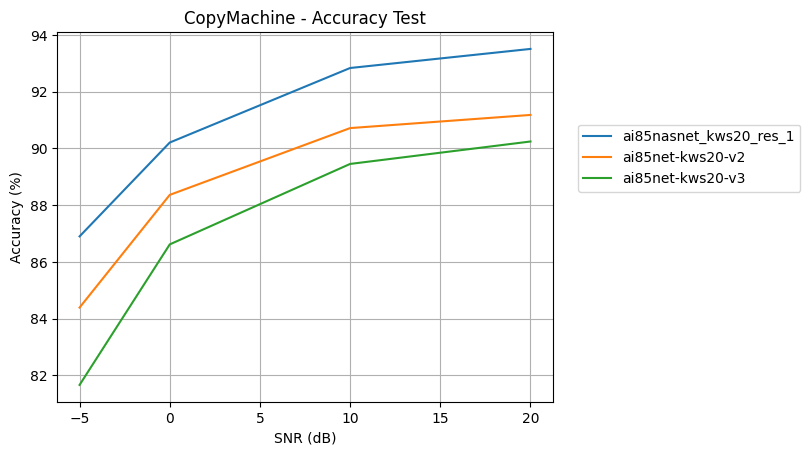

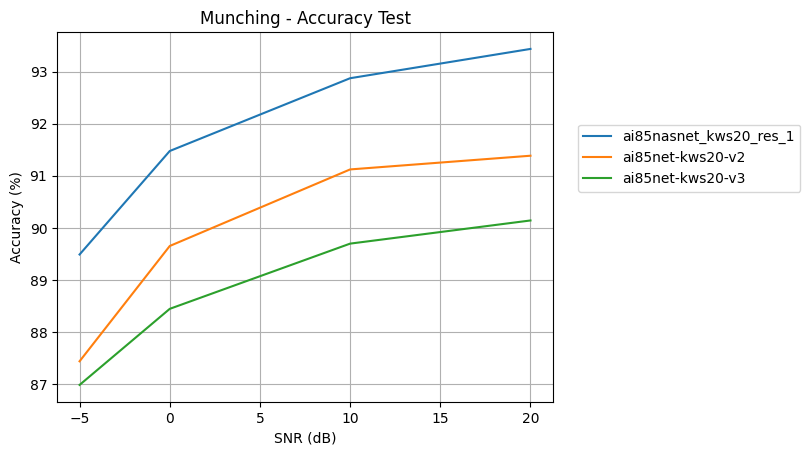

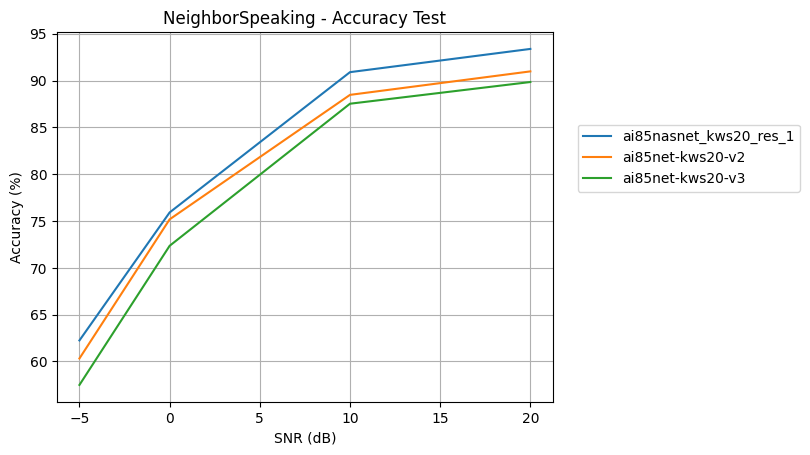

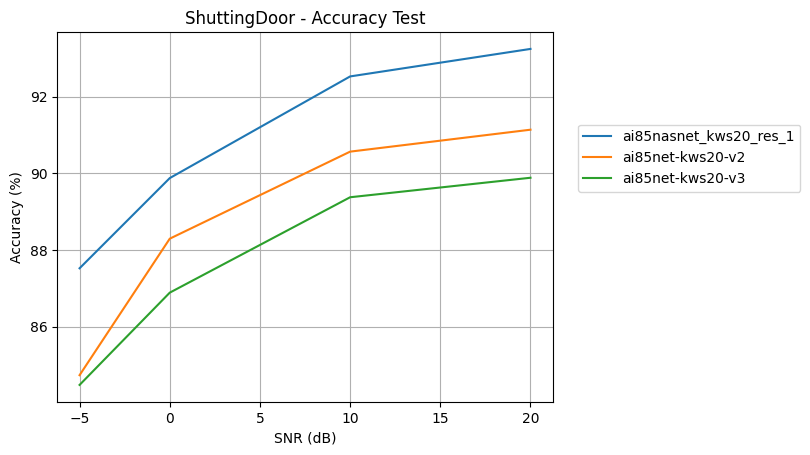

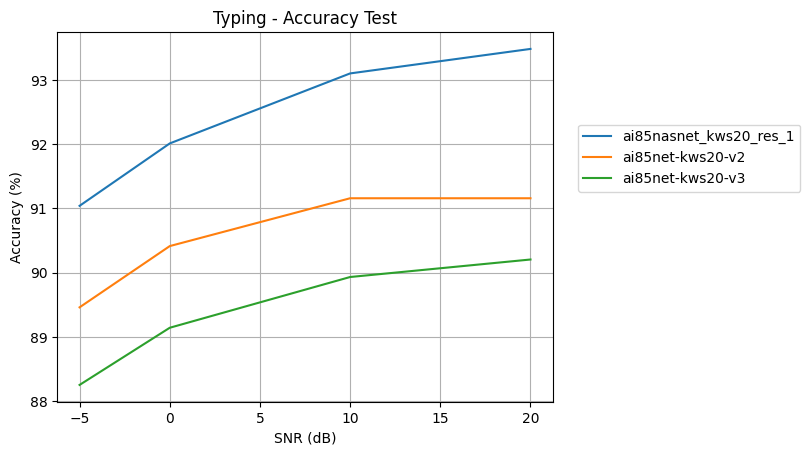

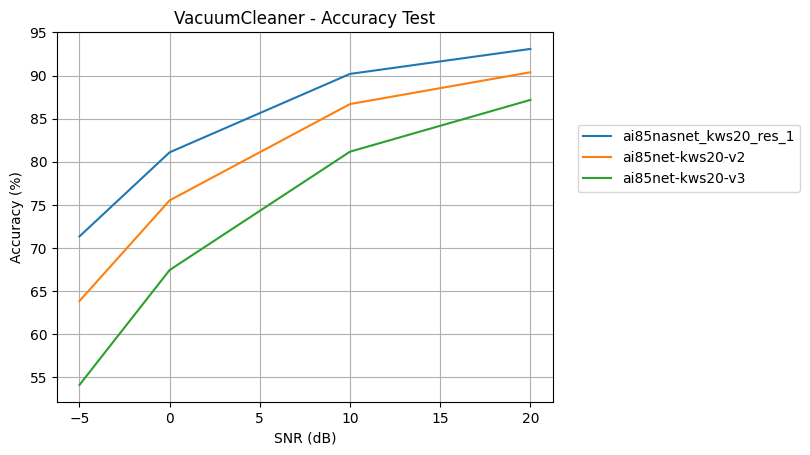

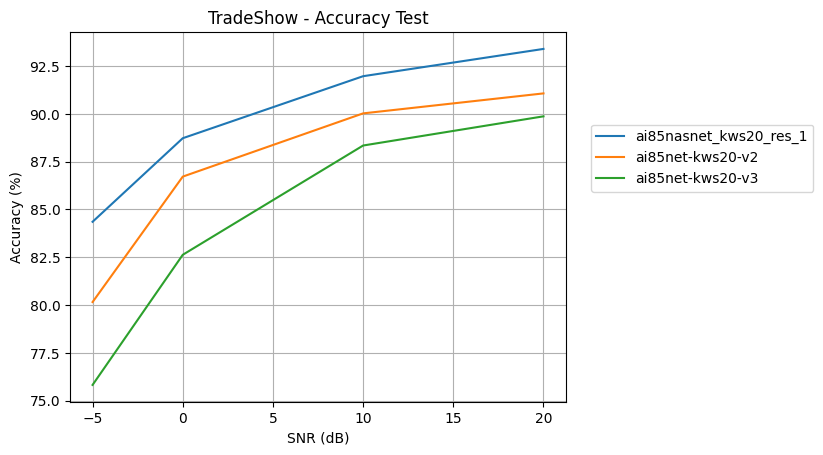

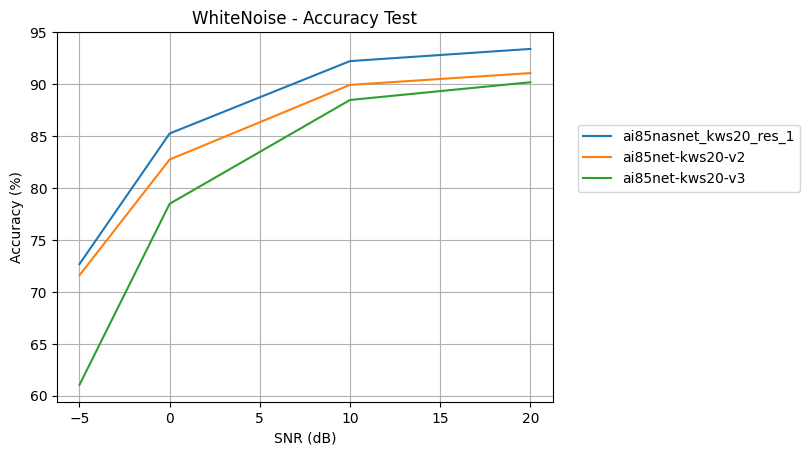

In [25]:
snr = [-5, 0, 10, 20]
acc_list = []
for model_num in data_files.columns[2:]:
    acc_list.append(plot(model_num))
    
for noise in noise_list:
    plt.figure()
    plt.grid()
    plt.title(f'{noise} - Accuracy Test')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy (%)')
    for model in acc_list:
        plt.plot(snr , model[noise])

    plt.legend(data_files.columns[2:], bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)

/tmp/ipykernel_3504128/2098196639.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


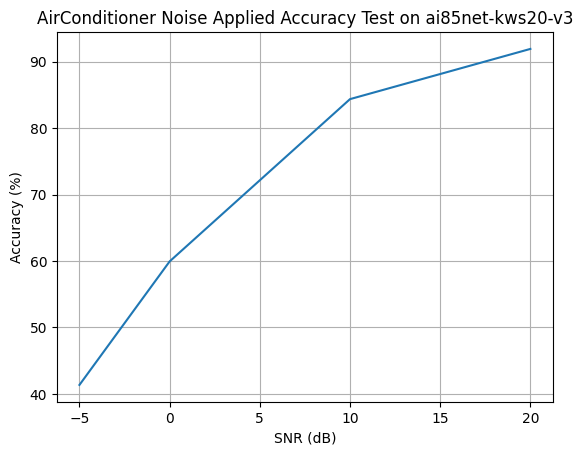

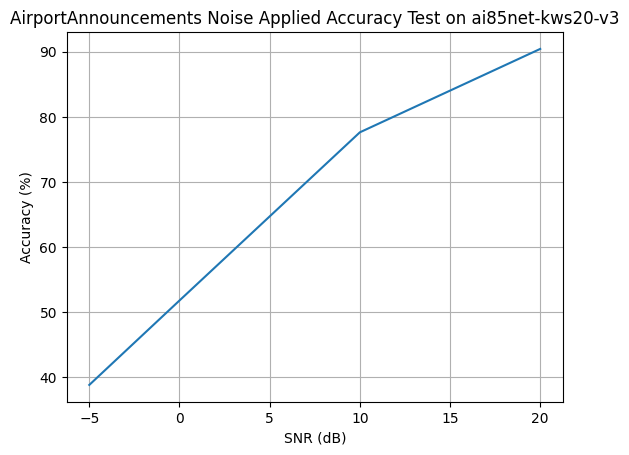

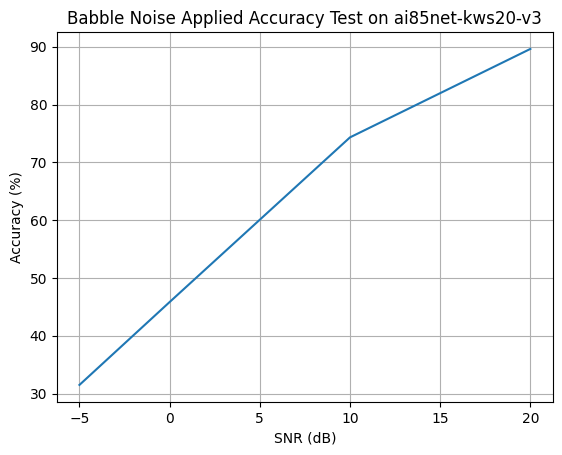

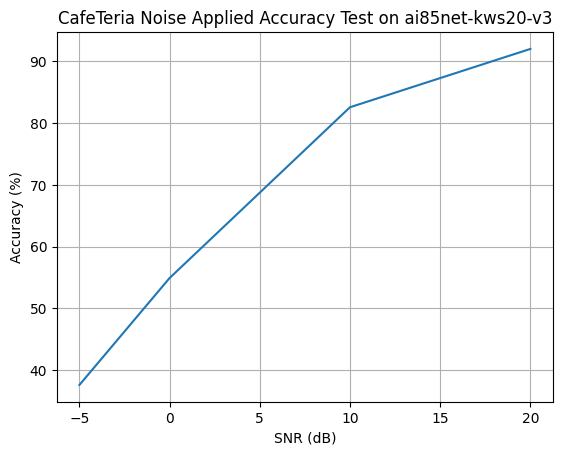

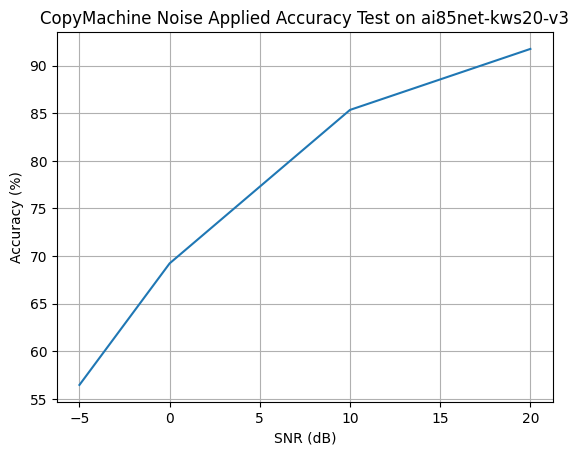

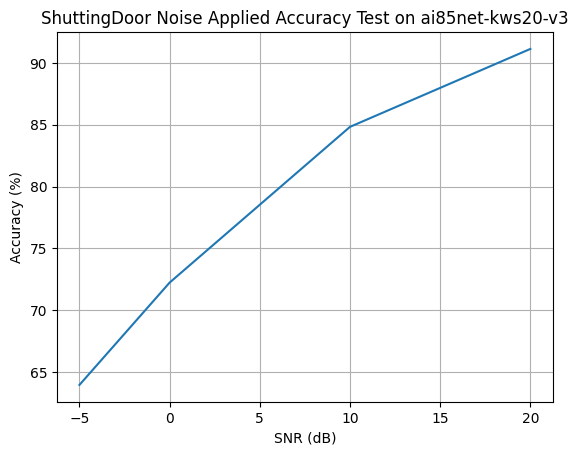

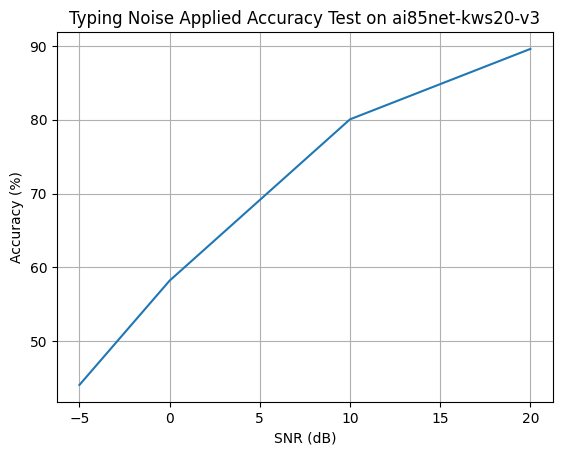

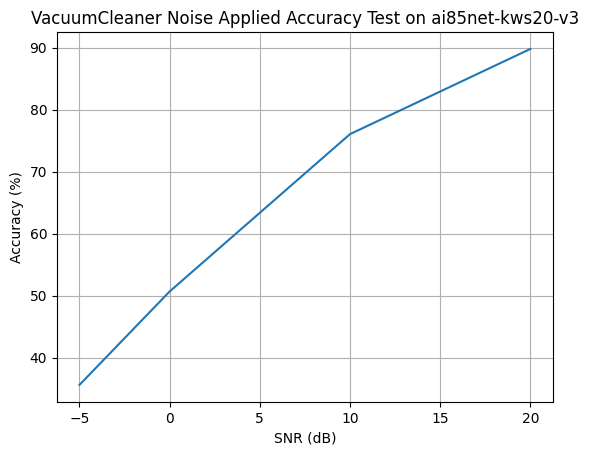

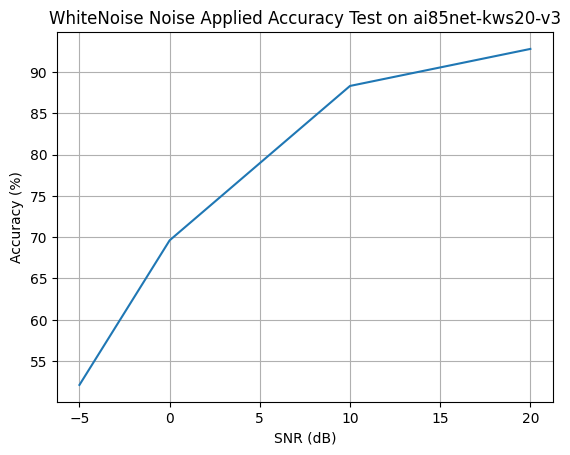

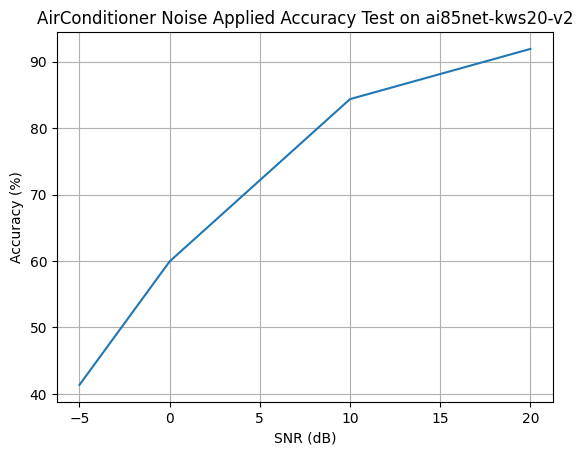

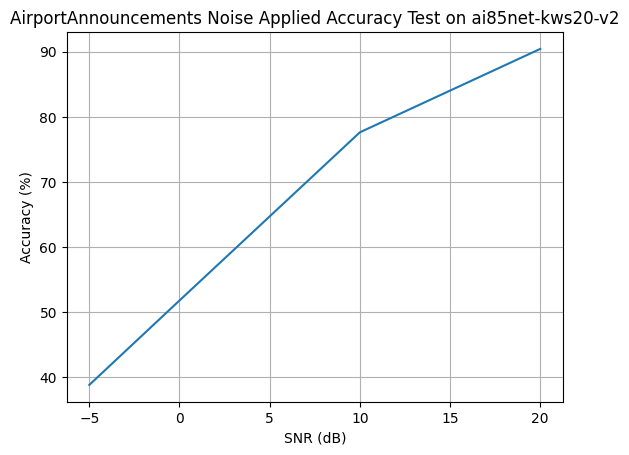

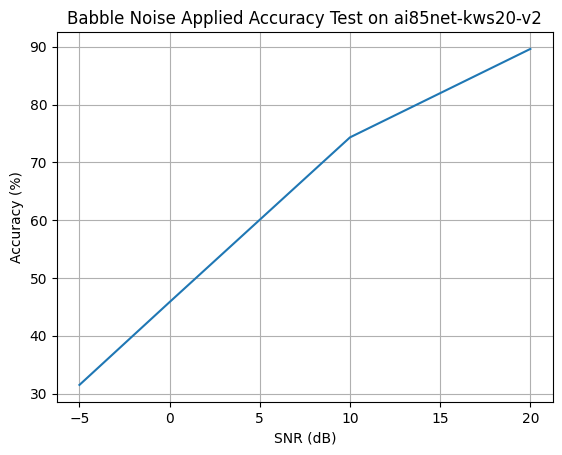

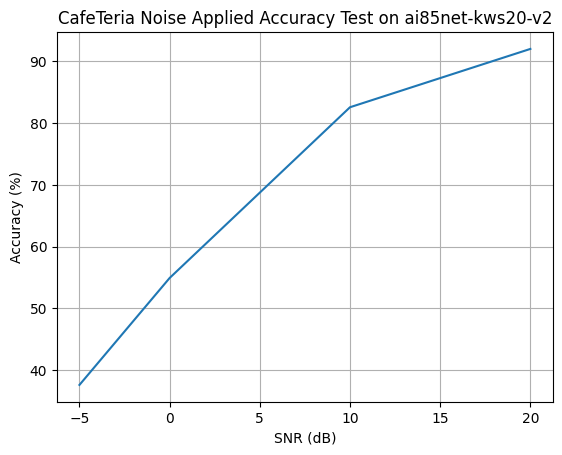

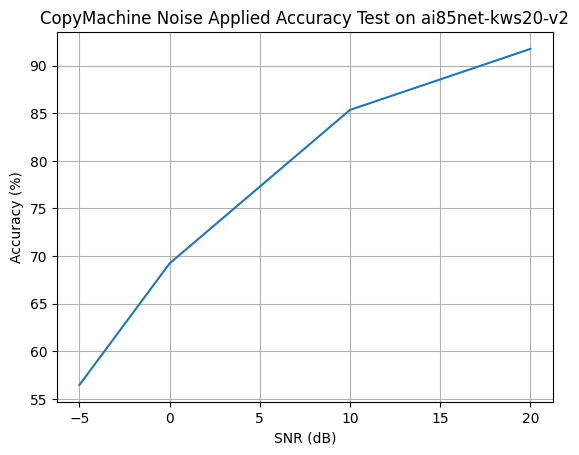

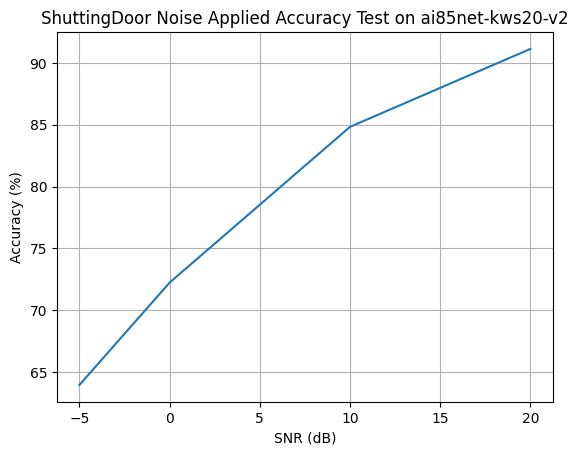

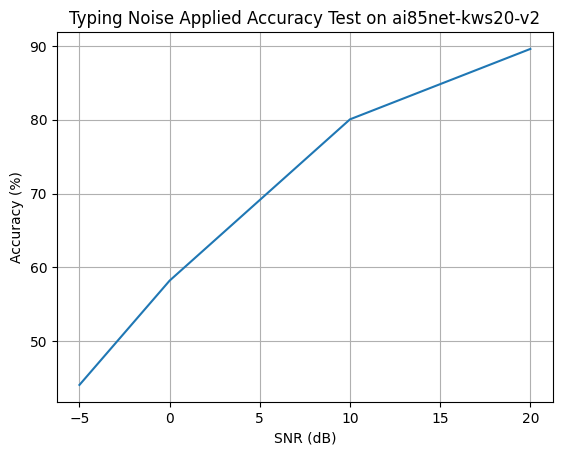

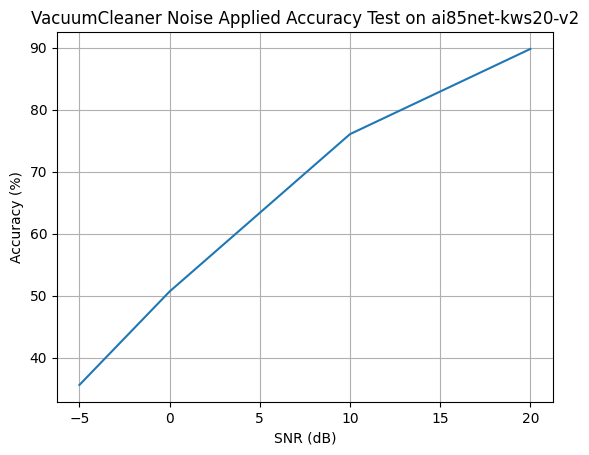

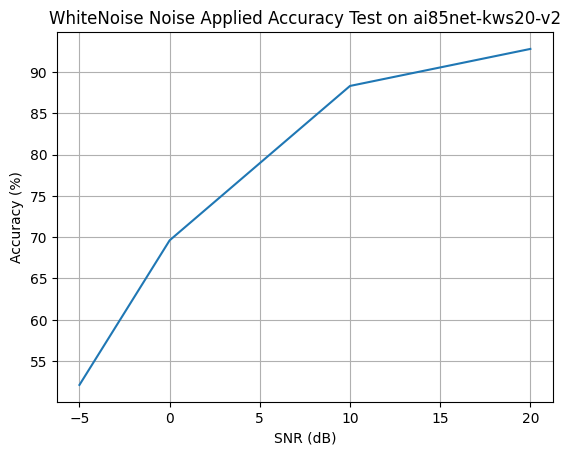

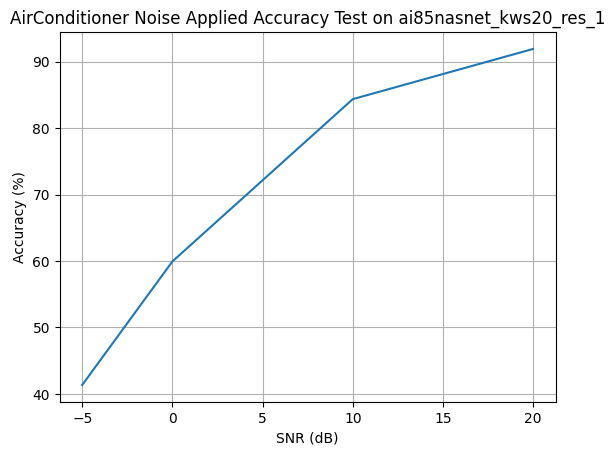

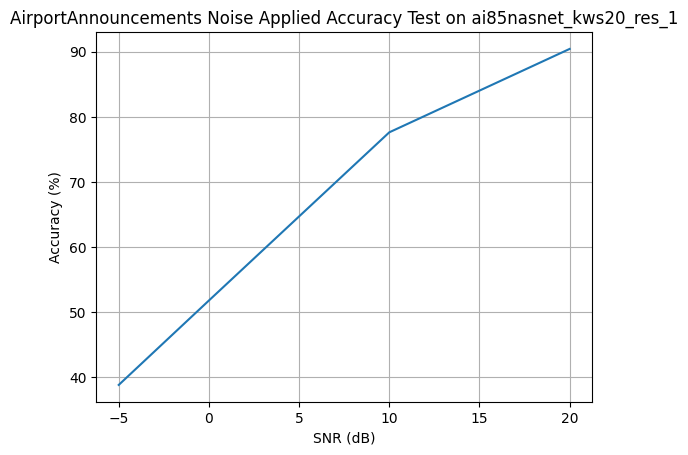

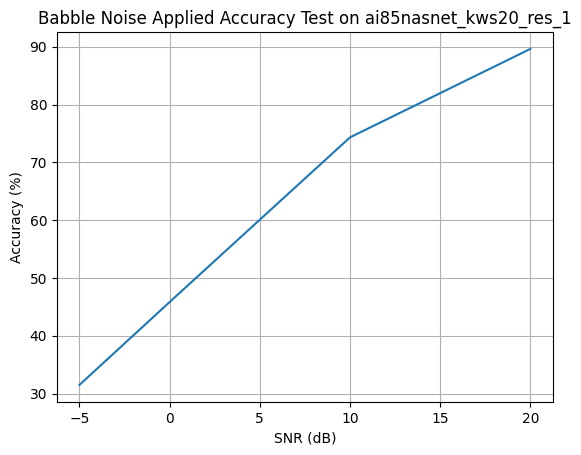

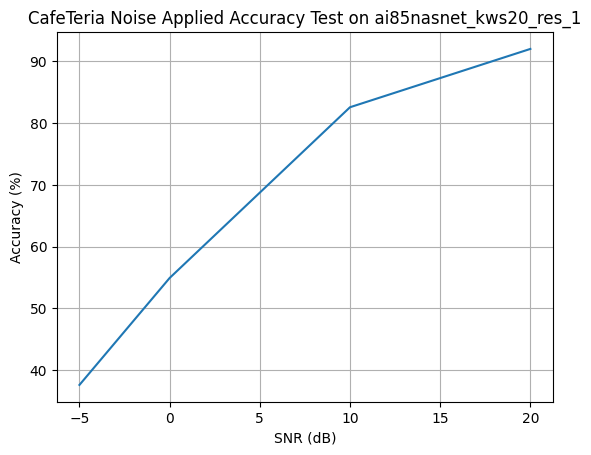

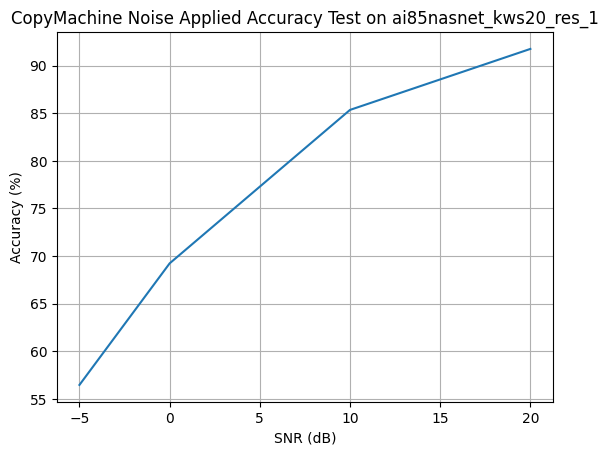

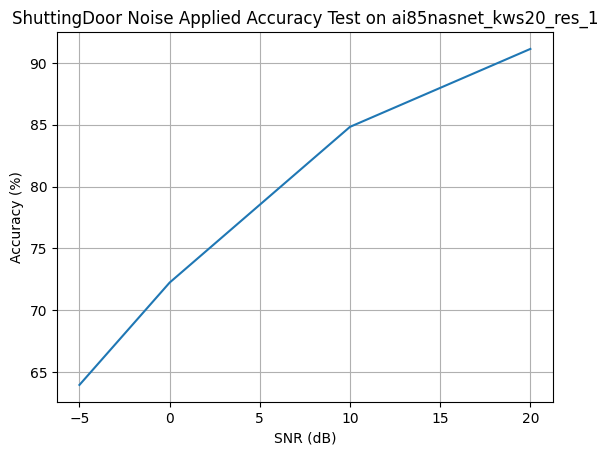

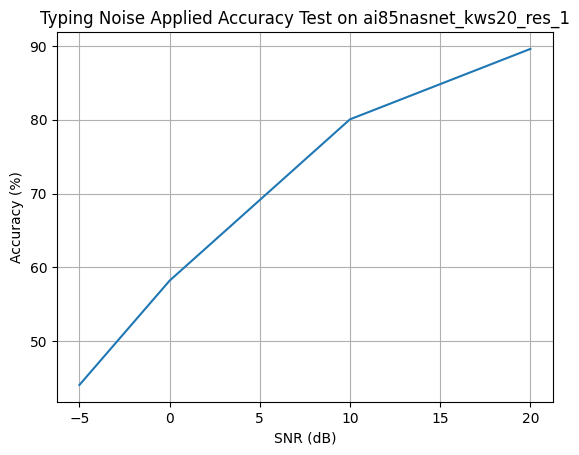

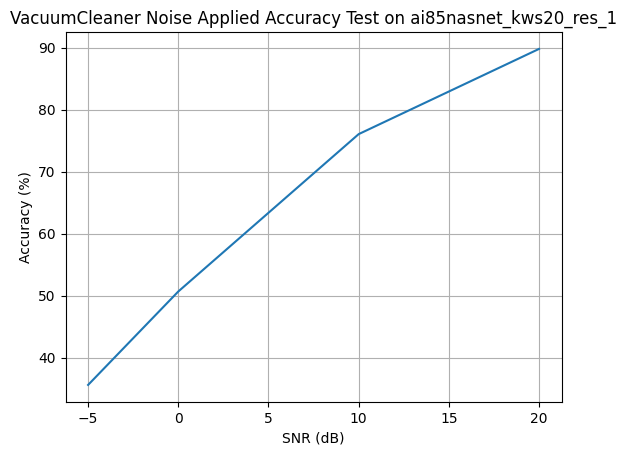

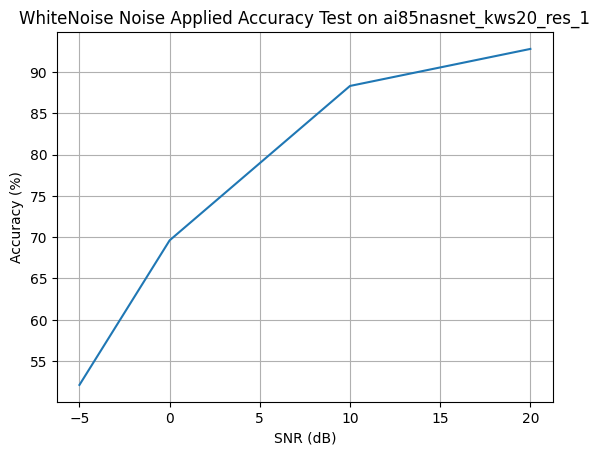

In [68]:
snr = [-5, 0, 10, 20]

for model_num in data_files.columns[2:]:
    for noise in noise_list:
        plt.figure()
        plt.grid()
        plt.title(f'{noise} Noise Applied Accuracy Test on {model_num}')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy (%)')
        plt.plot(snr, accuracies_values[noise])